In [1]:
from astropy.modeling import models, Fittable1DModel, Parameter
from astropy.modeling import fitting
import astropy.units as u
import astropy.constants as const

from spectacle.spectrum import SpectrumModel
from spectacle.registries import line_registry

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
# plt.rcParams["figure.figsize"] = [8, 16]
# plt.rcParams["figure.dpi"] = 80

## Control Spectrum

This spectrum acts as the standard to which the dynamic spectrum will be compared in the correlation metrics.

In [3]:
import astropy.units as u

wavelength = np.linspace(1210, 1250, 1001) * u.Angstrom
velocity = np.linspace(-800, 1800, 201) * u.Unit("km/s")

  name  
--------
  HI1216
  HI1026
   HI973
   HI950
   HI938
   HI931
   HI926
   HI923
   HI921
   HI919
     ...
NiII1467
NiII1455
NiII1393
NiII1370
NiII1317
CuII1368
CuII1359
ZnII2063
ZnII2026
GeII1602
GaII1414
Length = 329 rows
 name     wave   osc_str    gamma   
        Angstrom                    
------ --------- ------- -----------
HI1216 1215.6701  0.4164 626500000.0
Correct name is HI1216 given HI1215.
1215.6701
Correct name is HI1216 given HI1216.


<IPython.core.display.Javascript object>


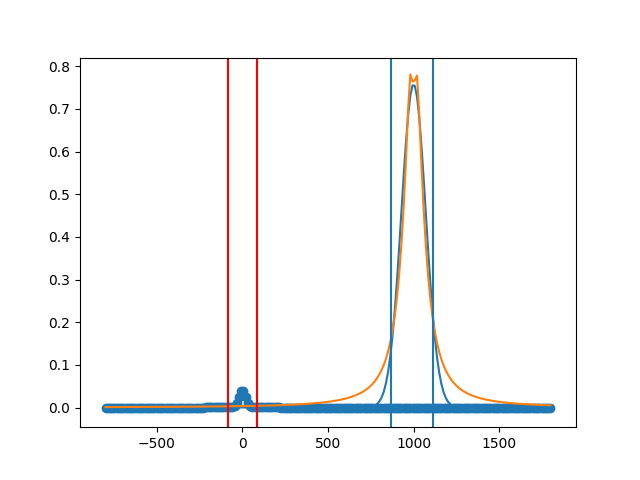

Model: Voigt1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         x_0       amplitude_L       fwhm_L        fwhm_G    
        km / s                       km / s        km / s    
    ------------- -------------- ------------- --------------
    1000.02369364 0.853647385297 125.932659762 -30.2398158089


In [4]:
from spectacle.models import TauProfile
from astropy.modeling.models import Voigt1D
from astropy.modeling.fitting import LevMarLSQFitter

print(line_registry['name'])
print(line_registry[line_registry['name'] == 'HI1216'])
line = line_registry.with_name('HI1215')
print(line['wave'])

spectrum = SpectrumModel(center=line['wave']).add_line(name='HI1216', 
                                                       column_density=1e14 * u.Unit('1/cm2'),
                                                       v_doppler=1e7 * u.Unit('cm/s'),
                                                       delta_v=1000 * u.Unit('km/s'))

voigt = Voigt1D(x_0=0.0001, amplitude_L=0.17, fwhm_G=40, fwhm_L=8)

fitter = LevMarLSQFitter()

new_voigt = fitter(voigt, velocity, spectrum.tau(velocity))

f, ax = plt.subplots()

ax.plot(velocity, spectrum.tau(velocity))
ax.scatter(velocity, voigt(velocity.value))

print(new_voigt)
ax.plot(velocity, new_voigt(velocity))



# fwhm = line.fwhm(velocity, velocity=True)
# print(fwhm)

# ax.axvline(line['lambda_0']-fwhm*0.5)
# ax.axvline(line['lambda_0']+fwhm*0.5)

# ax.axvline(line['lambda_0']-fwhm)
# ax.axvline(line['lambda_0']+fwhm)

# mask = spectrum.line_mask(velocity)
# ax.scatter(velocity[mask], spectrum.tau.velocity_space(velocity, center=line['lambda_0'])[mask])
vmn, vmx = spectrum._line_model.dv90()

# for line in spectrum._line_model:
#     print(line.dv90(wavelength))

In [5]:
ax.axvline(vmn.value)
ax.axvline(vmx.value)

In [6]:
fwhm = spectrum._line_model.fwhm().value
ax.axvline(-fwhm*0.5, color='r')
ax.axvline(fwhm*0.5, color='r')

None


<IPython.core.display.Javascript object>


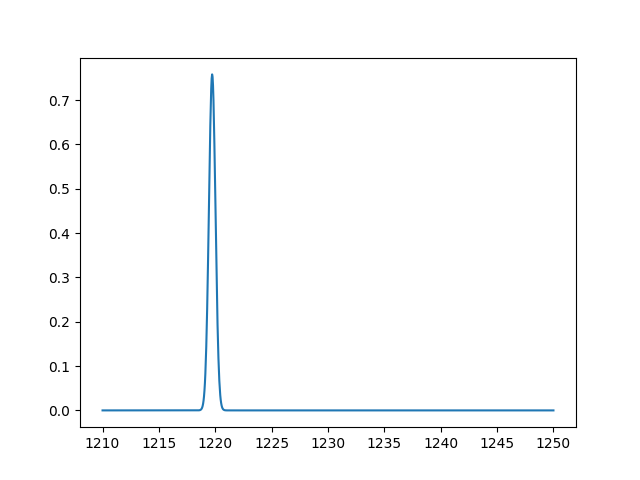

In [7]:
nspec = SpectrumModel()
nspec.from_data(wavelength, spectrum(wavelength), smooth=False)

print(nspec)

f, ax = plt.subplots()

ax.plot(wavelength, spectrum(wavelength))